In [1]:
import cv2
import matplotlib.pyplot as plt
from preprocess_images import apply_circular_mask, process_for_stopping_criteria
import numpy as np
from skimage.metrics import structural_similarity as ssim
import torch
import torch.nn as nn
import os


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


In [2]:
def to_square(img, t_x, t_y, b_x, b_y):
    h, w = img.shape[:2]
    m_x = w//2 + b_x
    m_y = h//2 + b_y
    return img[m_y-t_y//2:m_y+t_y//2,m_x-t_x//2:m_x+t_x//2]  

def high_pass(img, t):
    new = np.copy(img)
    new[img<t] = 0
    return new

def hp_fft(img, cutoff=0.05):
    """
    Apply a high-pass filter to a single-channel or multi-channel image.
    img: (C, H, W) or (1, H, W), values in [0,1]
    cutoff: relative cutoff frequency (0 to 0.5)
    """
    if isinstance(img, np.ndarray):
        img = torch.from_numpy(img).permute(2,0,1).float()
    if img.ndim == 2:
        img = img.unsqueeze(0)  # convert to (1, H, W)

    img = img.to(DEVICE)  # move to correct device
    
    C, H, W = img.shape
    freq = torch.fft.fft2(img, dim=(-2, -1))
    freq_shifted = torch.fft.fftshift(freq)

    # Create high-pass mask
    y = torch.linspace(-1, 1, H, device=img.device)
    x = torch.linspace(-1, 1, W, device=img.device)
    yy, xx = torch.meshgrid(y, x, indexing='ij')
    radius = torch.sqrt(xx**2 + yy**2)
    mask = (radius >= cutoff).float()

    filtered = freq_shifted * mask
    inv_shifted = torch.fft.ifftshift(filtered)
    result = torch.fft.ifft2(inv_shifted, dim=(-2, -1)).real

    return result.clamp(0, 1)

In [3]:
def apply_circular_mask(image_array, radius):
    """Applies a circular mask that blackens everything outside a centered circle."""
    h, w = image_array.shape[:2]
    center = (w // 2, h // 2)

    # Create a black mask with a white circle in the center
    mask = np.zeros((h, w), dtype=np.uint8)
    mask = cv2.circle(mask, center, radius, 255, -1)

    result = np.zeros_like(image_array)
    result[mask == 255] = image_array[mask == 255]

    return result

-1


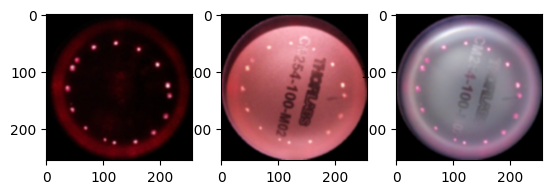

In [4]:
print(cv2.IMREAD_UNCHANGED)
color_dark = cv2.imread("/mnt/h/color_dark/x0.00_y0.00.jpg", cv2.IMREAD_COLOR_RGB)
color_light = cv2.imread("/mnt/h/color_light/x0.00_y0.00.jpg", cv2.IMREAD_COLOR_RGB)
color_main_light = cv2.imread("/mnt/h/color_mainlight_004/x0.00_y0.00.jpg", cv2.IMREAD_COLOR_RGB)

fig, axes = plt.subplots(1,3)
axes[0].imshow(color_dark)
axes[1].imshow(color_light)
axes[2].imshow(color_main_light)

plt.show()

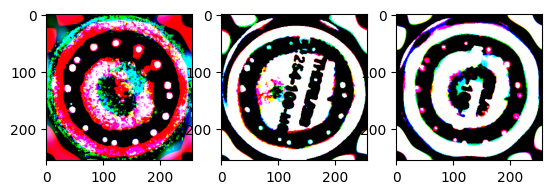

In [5]:
c = 0.03
hpfft_dark = hp_fft(color_dark, cutoff=c).permute(1,2,0).cpu()
hpfft_light = hp_fft(color_light, cutoff=c).permute(1,2,0).cpu()
hpfft_main_light = hp_fft(color_main_light, cutoff=c).permute(1,2,0).cpu()


fig, axes = plt.subplots(1,3)
axes[0].imshow(hpfft_dark)
axes[1].imshow(hpfft_light)
axes[2].imshow(hpfft_main_light)

plt.show()

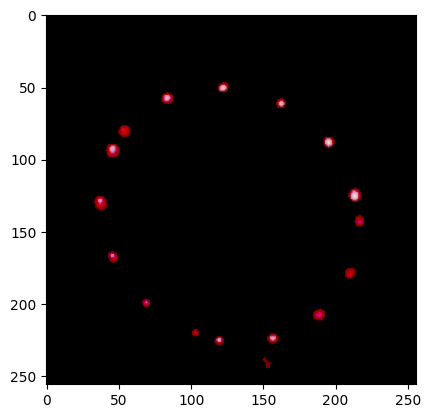

In [6]:
highpassdark = high_pass(color_dark, 120)
plt.imshow(highpassdark)
plt.show()

In [7]:
def hp_colors_q(img, rq, rg, rb):
    red = 0
    green = 1
    blue = 2
    
    img = np.copy(img)
    print(img.shape)
    t_r = np.quantile(img[:,:,red], rq)
    t_g = np.quantile(img[:,:,green], rg)
    t_b = np.quantile(img[:,:,blue], rb)

    img[:,:,red] = high_pass(img[:,:,red], t_r)
    img[:,:,green] = high_pass(img[:,:,green], t_g)
    img[:,:,blue] = high_pass(img[:,:,blue], t_b)
    return img

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


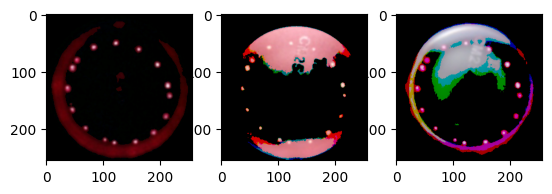

In [8]:
red = 0
green = 1
blue = 2
t_r = 0.8
t_g = 0.8
t_b = 0.8
print(color_dark.shape)
hp_dark = hp_colors_q(color_dark, t_r, t_g, t_b)
hp_light = hp_colors_q(color_light, t_r, t_g, t_b)
hp_main_light = hp_colors_q(color_main_light, t_r, t_g, t_b)


fig, axes = plt.subplots(1,3)
axes[0].imshow(hp_dark)
axes[1].imshow(hp_light)
axes[2].imshow(hp_main_light)

plt.show()

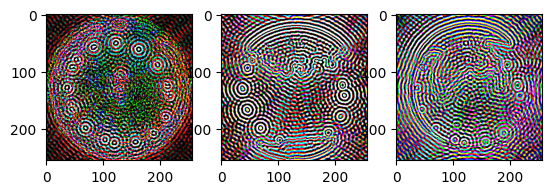

In [9]:
c = 0.3
hpc_hpfft_dark = hp_fft(hp_dark, cutoff=c).permute(1,2,0).cpu()
hpc_hpfft_light = hp_fft(hp_light, cutoff=c).permute(1,2,0).cpu()
hpc_hpfft_main_light = hp_fft(hp_main_light, cutoff=c).permute(1,2,0).cpu()


fig, axes = plt.subplots(1,3)
axes[0].imshow(hpc_hpfft_dark)
axes[1].imshow(hpc_hpfft_light)
axes[2].imshow(hpc_hpfft_main_light)

plt.show()

In [10]:
def gaussian_kernel(kernel_size, sigma):
        """Create 2D Gaussian kernel centered in the middle."""
        ax = np.linspace(-(kernel_size - 1) / 2., (kernel_size - 1) / 2., kernel_size)
        xx, yy = np.meshgrid(ax, ax)
        kernel = np.exp(-(xx**2 + yy**2) / (2. * sigma**2))
        return torch.tensor(kernel, dtype=torch.float32)

def point_kernel(ksize, point_size, sigma):
        assert(ksize >= point_size)
        d = (ksize - point_size)//2
        inner = gaussian_kernel(point_size, sigma)

        kernel = np.ones((ksize, ksize), dtype=np.float32)
        kernel = -1*kernel/np.sum(kernel)

        kernel[d:-d,d:-d] = inner
        return torch.from_numpy(kernel)

In [11]:
np.ones((3, 3), dtype=np.float32)*-1

array([[-1., -1., -1.],
       [-1., -1., -1.],
       [-1., -1., -1.]], dtype=float32)

tensor(-0.0016)
tensor(0.3679)


/tmp/ipykernel_1430024/3518012752.py:16: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  kernel[d:-d,d:-d] = inner


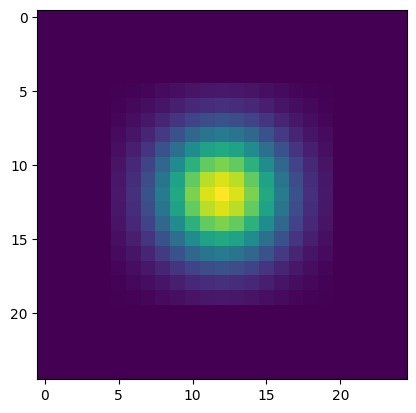

In [12]:
k = point_kernel(25, 15, 3)
print(k[0,0])
print(k[15,15])
plt.imshow(k)
plt.show()

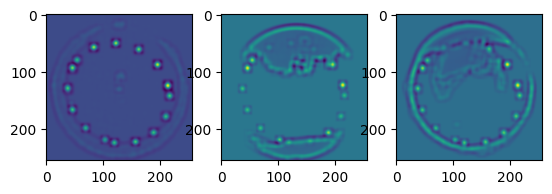

In [13]:
ks = 15
s = 3.5
a = 3
d = 1
gauss_conv = nn.Conv2d(in_channels=3, out_channels=1, kernel_size=ks, bias=False, padding=7)
with torch.no_grad():
    gauss_conv.weight.zero_()  # Zero all weights first
    gauss_conv.weight[0, 2] = gaussian_kernel(ks, s)*a-d
    gauss_conv.weight[0, 1] = gaussian_kernel(ks, s)*a-d
    gauss_conv.weight[0, 0] = gaussian_kernel(ks, s)*a-d


proc_dark = torch.from_numpy(hp_dark).permute(2,0,1)/255
proc_light = torch.from_numpy(hp_light).permute(2,0,1)/255
proc_main_light = torch.from_numpy(hp_main_light).permute(2,0,1)/255

with torch.no_grad():
    r_dark = gauss_conv(proc_dark).permute(1,2,0).cpu().numpy()
    r_light = gauss_conv(proc_light).permute(1,2,0).cpu().numpy()
    r_main_light = gauss_conv(proc_main_light).permute(1,2,0).cpu().numpy()

r_dark += abs(r_dark.min())
r_light += abs(r_light.min())
r_main_light += abs(r_main_light.min())

fig, axes = plt.subplots(1,3)
axes[0].imshow(r_dark)
axes[1].imshow(r_light)
axes[2].imshow(r_main_light)

plt.show()

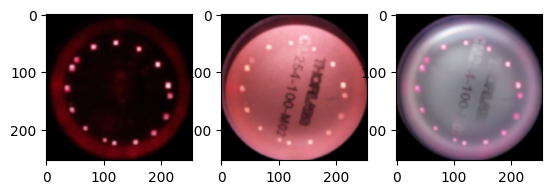

In [14]:
mpool = nn.MaxPool2d(3, 1)

m_dark = mpool(torch.from_numpy(color_dark).permute(2,0,1)).permute(1,2,0).numpy()
m_light = mpool(torch.from_numpy(color_light).permute(2,0,1)).permute(1,2,0).numpy()
m_main_light = mpool(torch.from_numpy(color_main_light).permute(2,0,1)).permute(1,2,0).numpy()

fig, axes = plt.subplots(1,3)
axes[0].imshow(m_dark)
axes[1].imshow(m_light)
axes[2].imshow(m_main_light)

plt.show()

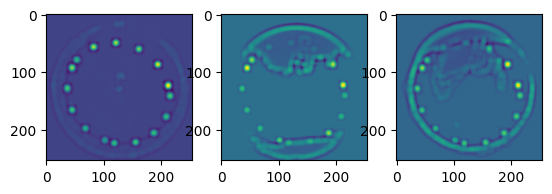

In [15]:
m_dark = mpool(torch.from_numpy(r_dark).permute(2,0,1)).permute(1,2,0).numpy()
m_light = mpool(torch.from_numpy(r_light).permute(2,0,1)).permute(1,2,0).numpy()
m_main_light = mpool(torch.from_numpy(r_main_light).permute(2,0,1)).permute(1,2,0).numpy()

fig, axes = plt.subplots(1,3)
axes[0].imshow(m_dark)
axes[1].imshow(m_light)
axes[2].imshow(m_main_light)

plt.show()

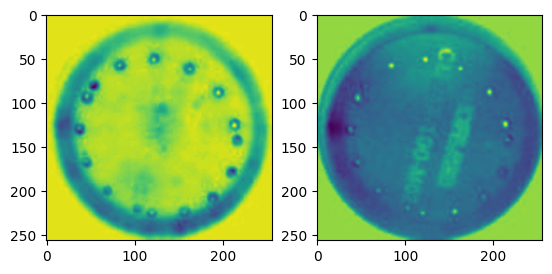

In [16]:
conv = nn.Conv2d(in_channels=3, out_channels=1, kernel_size=1, bias=False, padding=0)

# Define the filter
with torch.no_grad():
    conv.weight.zero_()  # Zero all weights first
    conv.weight[0, 1] = 0.47  # Set the red channel (channel 0) to ones
    conv.weight[0, 2] = 0.014
    conv.weight[0, 0] = -0.41


proc_dark = torch.from_numpy(color_dark).permute(2,0,1)/255
proc_light = torch.from_numpy(color_light).permute(2,0,1)/255
proc_main_light = torch.from_numpy(color_main_light).permute(2,0,1)/255

with torch.no_grad():
    r_dark = conv(proc_dark).permute(1,2,0).cpu().numpy()
    r_light = conv(proc_light).permute(1,2,0).cpu().numpy()

# c = 0
# t = 100
# r_dark = high_pass(color_dark[:,:,c], t)
# r_light = high_pass(color_light[:,:,c], t)



fig, axes = plt.subplots(1,2)
axes[0].imshow(r_dark)
axes[1].imshow(r_light)

plt.show()

In [17]:
clahe = cv2.createCLAHE(clipLimit=5)

In [18]:
config = {
    "experiment_name": "004step_CnnExtractor_3colorDeepColorMP_512bs_0001lr_aug+",
    "batch_size": 512,
    "lr": 0.0005,
    "lr_scheduler_loop": 20,
    "epochs": 20,
    "use_amp": False,

    # "data_folder": "/mnt/h/real_512_0_001step.lmdb",
    "data_folder": "/mnt/e/color.lmdb",
    "dataset_type": "LMDBImageDataset",
    "dataset_config_flatten": False,
    "dataset_train_keys_fname": "004_color_train.txt",
    "dataset_val_keys_fname": "004_color_val.txt",

    "noise_level": 0.1,
    "jitter_brightness": 0.4, 
    "jitter_contrast": 0.1, 
    "jitter_saturation": 0.1, 
    "jitter_hue": 0.2,

    "use_clahegrad_transform": False,
    "clahe_clip_limit": 0.001,
    "clahe_gaussian_size": 15,
    "clahe_gaussian_sigma": 5,

    "data_collection_step": 0.0001,
    "starting_checkpoint_fname": None,
    "checkpoint_folder": "./saved_models/real",

    "conv_stride": 1,
    "conv_kernel": 1,
    "conv_kernel_1": 13,
    "conv_depth": 2,

    "gradient_layer_kernel_size": 15,
    "gradient_layer_sigma": 5,

    "use_weight_initialization": False,
    "init_red_filter": False
}

In [19]:

class LearnableNormalizer(nn.Module):
    def __init__(self, kernel_size=15, sigma=3.5, a=3, d=1):
        super().__init__()
        self.conv = nn.Conv2d(3, 1, kernel_size=kernel_size, padding=kernel_size // 2, bias=False)
        self.init_weights(kernel_size, sigma, a, d)
        self.activaltion = nn.Sigmoid()
    def gaussian_kernel(self, kernel_size, sigma):
        """Create 2D Gaussian kernel centered in the middle."""
        ax = torch.linspace(-(kernel_size - 1) / 2., (kernel_size - 1) / 2., kernel_size)
        xx, yy = torch.meshgrid(ax, ax, indexing='ij')
        kernel = torch.exp(-(xx**2 + yy**2) / (2. * sigma**2))
        return kernel

    def init_weights(self, kernel_size, sigma, a, d):
        with torch.no_grad():
            self.conv.weight.zero_()
            kernel = self.gaussian_kernel(kernel_size, sigma)
            weighted_kernel = kernel * a - d
            for c in range(3):
                self.conv.weight[0, c] = weighted_kernel

    def forward(self, x):
        return self.activaltion(self.conv(x))

class CnnShallowColor(nn.Module):
    """Input.shape = (3, 256, 256)"""
    def __init__(self, output_size):
        super(CnnShallowColor, self).__init__()
        ksize0 = config["conv_kernel"]
        self.sec1 = LearnableNormalizer(ksize0)
        for param in self.sec1.parameters():
            param.requires_grad = False

        self.sec2 = nn.Sequential(
            nn.Linear(256*256, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(),
            nn.Linear(1024, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(),
            nn.Linear(256, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(),
            nn.Linear(32, output_size),
        )

    def forward(self, x:torch.Tensor):
        x = self.sec1(x)
        x = torch.squeeze(x)
        x = torch.flatten(x, 1)
        x = self.sec2(x)

        return x
def load_model(model:torch.nn.Module, fname="best_model.pth", path="./saved_models/real"):
    model.load_state_dict(torch.load(os.path.join(path,fname), weights_only=False))
    return model
    
model = CnnShallowColor(2).to(DEVICE)
model = load_model(model, fname="004step_CnnShallow_512bs_0001lr_aug+_best_model.pth")

In [20]:
ext_dark = model.sec1(proc_dark.to(DEVICE).unsqueeze(0)).cpu().detach().squeeze(0).permute(1,2,0)
ext_light = model.sec1(proc_light.to(DEVICE).unsqueeze(0)).cpu().detach().squeeze(0).permute(1,2,0)
ext_main_light = model.sec1(proc_main_light.to(DEVICE).unsqueeze(0)).cpu().detach().squeeze(0).permute(1,2,0)

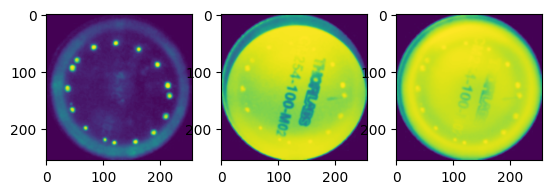

In [21]:
fig, axes = plt.subplots(1,3)
axes[0].imshow(ext_dark)
axes[1].imshow(ext_light)
axes[2].imshow(ext_main_light)

plt.show()

# Histogram Equalization

In [22]:
dark_path = "/mnt/h/latest_real_data/real_data/real/x0.00_y0.00.jpg"
lamp_path = "/mnt/h/latest_real_data/light/x0.00_y0.00.jpg"
light_path = "/mnt/h/newlight/main_light/x0.00_y0.00.jpg"

skewed_dark_path = "/mnt/h/latest_real_data/real_data/real/x1.00_y0.50.jpg"
skewed_lamp_path = "/mnt/h/latest_real_data/light/x1.00_y0.50.jpg"
skewed_light_path = "/mnt/h/newlight/main_light/x1.00_y0.50.jpg"

scatter_dark_path = "/mnt/h/latest_real_data/real_data/real/x1.12_y-1.16.jpg"
scatter_lamp_path = "/mnt/h/latest_real_data/light/x1.12_y-1.16.jpg"
scatter_light_path = "/mnt/h/newlight/main_light/x1.12_y-1.16.jpg"

dark = cv2.imread(dark_path, cv2.IMREAD_GRAYSCALE)
lamp = cv2.imread(lamp_path, cv2.IMREAD_GRAYSCALE)
light = cv2.imread(light_path, cv2.IMREAD_GRAYSCALE)

skewed_dark = cv2.imread(skewed_dark_path, cv2.IMREAD_GRAYSCALE)
skewed_lamp = cv2.imread(skewed_lamp_path, cv2.IMREAD_GRAYSCALE)
skewed_light = cv2.imread(skewed_light_path, cv2.IMREAD_GRAYSCALE)

scatter_dark = cv2.imread(scatter_dark_path, cv2.IMREAD_GRAYSCALE)
scatter_lamp = cv2.imread(scatter_lamp_path, cv2.IMREAD_GRAYSCALE)
scatter_light = cv2.imread(scatter_light_path, cv2.IMREAD_GRAYSCALE)

[ WARN:0@4.718] global loadsave.cpp:268 findDecoder imread_('/mnt/h/latest_real_data/real_data/real/x0.00_y0.00.jpg'): can't open/read file: check file path/integrity
[ WARN:0@4.719] global loadsave.cpp:268 findDecoder imread_('/mnt/h/latest_real_data/light/x0.00_y0.00.jpg'): can't open/read file: check file path/integrity
[ WARN:0@4.735] global loadsave.cpp:268 findDecoder imread_('/mnt/h/latest_real_data/real_data/real/x1.00_y0.50.jpg'): can't open/read file: check file path/integrity
[ WARN:0@4.735] global loadsave.cpp:268 findDecoder imread_('/mnt/h/latest_real_data/light/x1.00_y0.50.jpg'): can't open/read file: check file path/integrity
[ WARN:0@4.744] global loadsave.cpp:268 findDecoder imread_('/mnt/h/latest_real_data/real_data/real/x1.12_y-1.16.jpg'): can't open/read file: check file path/integrity
[ WARN:0@4.744] global loadsave.cpp:268 findDecoder imread_('/mnt/h/latest_real_data/light/x1.12_y-1.16.jpg'): can't open/read file: check file path/integrity


Original zero


TypeError: Image data of dtype object cannot be converted to float

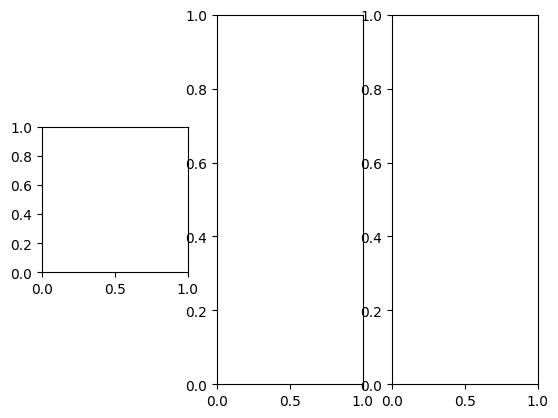

In [23]:
fig, axes = plt.subplots(1,3)
print("Original zero")
axes[0].imshow(dark)
axes[1].imshow(lamp)
axes[2].imshow(light)
plt.show()

In [ ]:
fig, axes = plt.subplots(1,3)
print("Original skewed")
axes[0].imshow(skewed_dark)
axes[1].imshow(skewed_lamp)
axes[2].imshow(skewed_light)
plt.show()

In [ ]:
fig, axes = plt.subplots(1,3)
print("Original scatter")
axes[0].imshow(scatter_dark)
axes[1].imshow(scatter_lamp)
axes[2].imshow(scatter_light)
plt.show()

In [ ]:
eqdark = cv2.equalizeHist(np.copy(dark))
eqlamp = cv2.equalizeHist(np.copy(lamp))
eqlight = cv2.equalizeHist(np.copy(light))

fig, axes = plt.subplots(1,3)
print("equalizeHist")
axes[0].imshow(eqdark)
axes[1].imshow(eqlamp)
axes[2].imshow(eqlight)
plt.show()

CLAHE


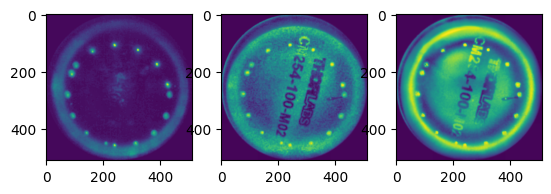

In [ ]:
clahe = cv2.createCLAHE(clipLimit=5)
aeqdark = clahe.apply(np.copy(dark))
aeqlamp = clahe.apply(np.copy(lamp))
aeqlight = clahe.apply(np.copy(light))

fig, axes = plt.subplots(1,3)
print("CLAHE")
axes[0].imshow(aeqdark)
axes[1].imshow(aeqlamp)
axes[2].imshow(aeqlight)
plt.show()

CLAHE


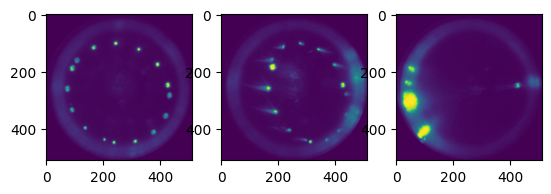

In [48]:
clahe = cv2.createCLAHE(clipLimit=0.1)

opt = cv2.imread("/mnt/h/dark512/x0.00_y0.00.jpg", cv2.IMREAD_GRAYSCALE)
skew = cv2.imread("/mnt/h/dark512/x1.00_y0.00.jpg", cv2.IMREAD_GRAYSCALE)
scatter = cv2.imread("/mnt/h/dark512/x-2.00_y0.00.jpg", cv2.IMREAD_GRAYSCALE)

aeqopt = clahe.apply(np.copy(opt))
aeqskew = clahe.apply(np.copy(skew))
aeqscatter = clahe.apply(np.copy(scatter))

fig, axes = plt.subplots(1,3)
print("CLAHE")
axes[0].imshow(aeqopt)
axes[1].imshow(aeqskew)
axes[2].imshow(aeqscatter)

plt.show()

HP


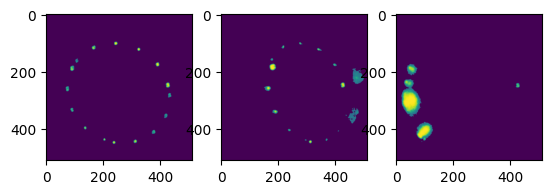

In [49]:
t = 90
hpaeqopt = high_pass(clahe.apply(np.copy(opt)), t)
hpaeqskew = high_pass(clahe.apply(np.copy(skew)), t)
hpaeqscatter = high_pass(clahe.apply(np.copy(scatter)), t)

fig, axes = plt.subplots(1,3)
print("HP")
axes[0].imshow(hpaeqopt)
axes[1].imshow(hpaeqskew)
axes[2].imshow(hpaeqscatter)

plt.show()

HP


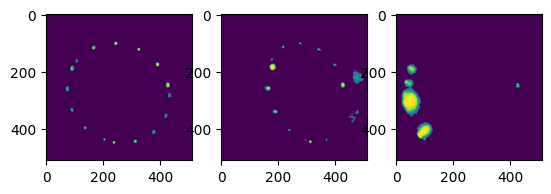

In [50]:
t = 90
hpopt = high_pass(np.copy(opt), t)
hpskew = high_pass(np.copy(skew), t)
hpscatter = high_pass(np.copy(scatter), t)

fig, axes = plt.subplots(1,3)
print("HP")
axes[0].imshow(hpopt)
axes[1].imshow(hpskew)
axes[2].imshow(hpscatter)

plt.show()

In [ ]:
def grad(gray):
    gray = cv2.GaussianBlur(gray, (15,15), 5)
    gX = cv2.Sobel(gray, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=3)
    gY = cv2.Sobel(gray, ddepth=cv2.CV_32F, dx=0, dy=1, ksize=3)
    # the gradient magnitude images are now of the floating point data
    # type, so we need to take care to convert them back a to unsigned
    # 8-bit integer representation so other OpenCV functions can operate
    # on them and visualize them
    gX = cv2.convertScaleAbs(gX)
    gY = cv2.convertScaleAbs(gY)
    # combine the gradient representations into a single image
    return cv2.addWeighted(gX, 0.5, gY, 0.5, 0)

In [ ]:
grad_dark = grad(np.copy(dark))
grad_lamp = grad(np.copy(lamp))
grad_light = grad(np.copy(light))

fig, axes = plt.subplots(1,3)
print("grad")
axes[0].imshow(grad_dark)
axes[1].imshow(grad_lamp)
axes[2].imshow(grad_light)
plt.show()

In [ ]:
def clahegrad(input, lim = 0.001, ksize=(15,15), sigma=5, t=15):
    img = np.copy(input)
    img = high_pass(img, t)
    clahe = cv2.createCLAHE(clipLimit=lim)
    img = clahe.apply(img)
    img = cv2.GaussianBlur(img, ksize, sigma)
    gX = cv2.Sobel(img, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=3)
    gY = cv2.Sobel(img, ddepth=cv2.CV_32F, dx=0, dy=1, ksize=3)
    
    gX = cv2.convertScaleAbs(gX)
    gY = cv2.convertScaleAbs(gY)
    img = cv2.addWeighted(gX, 0.5, gY, 0.5, 0)
    img = apply_circular_mask(img, 250)
    # img = clahe.apply(img)
    return img

In [ ]:
grad_aeqdark = clahegrad(dark)
grad_aeqlamp = clahegrad(lamp)
grad_aeqlight = clahegrad(light)

fig, axes = plt.subplots(2,3)
print("clahe grad")
axes[0][0].imshow(dark, cmap='gray')
axes[0][1].imshow(lamp, cmap='gray')
axes[0][2].imshow(light, cmap='gray')
axes[1][0].imshow(grad_aeqdark, cmap='gray')
axes[1][1].imshow(grad_aeqlamp, cmap='gray')
axes[1][2].imshow(grad_aeqlight, cmap='gray')
axes[0][0].set_title("A")
axes[0][1].set_title("B")
axes[0][2].set_title("C")
axes[1][0].set_title("Processed A")
axes[1][1].set_title("Processed B")
axes[1][2].set_title("Processed C")

for i in range(2):
    for j in range(3):
        axes[i][j].set_xticks([])
        axes[i][j].set_yticks([])

plt.show()
fig.savefig("graphs/clahe_processing_zero.png", dpi=300, transparent=True)

In [ ]:
grad_aeqdark_skewed = clahegrad(skewed_dark)
grad_aeqlamp_skewed = clahegrad(skewed_lamp)
grad_aeqlight_skewed = clahegrad(skewed_light)

fig, axes = plt.subplots(2,3)
print("clahe grad")
axes[0][0].imshow(skewed_dark, cmap='gray')
axes[0][1].imshow(skewed_lamp, cmap='gray')
axes[0][2].imshow(skewed_light, cmap='gray')
axes[1][0].imshow(grad_aeqdark_skewed, cmap='gray')
axes[1][1].imshow(grad_aeqlamp_skewed, cmap='gray')
axes[1][2].imshow(grad_aeqlight_skewed, cmap='gray')
axes[0][0].set_title("A")
axes[0][1].set_title("B")
axes[0][2].set_title("C")
axes[1][0].set_title("Processed A")
axes[1][1].set_title("Processed B")
axes[1][2].set_title("Processed C")

for i in range(2):
    for j in range(3):
        axes[i][j].set_xticks([])
        axes[i][j].set_yticks([])

plt.show()
fig.savefig("graphs/clahe_processing_skewed.png", dpi=300, transparent=True)

In [ ]:
grad_aeqdark_scatter = clahegrad(scatter_dark)
grad_aeqlamp_scatter = clahegrad(scatter_lamp)
grad_aeqlight_scatter = clahegrad(scatter_light)

fig, axes = plt.subplots(2,3)
print("clahe grad")
axes[0][0].imshow(scatter_dark, cmap='gray')
axes[0][1].imshow(scatter_lamp, cmap='gray')
axes[0][2].imshow(scatter_light, cmap='gray')
axes[1][0].imshow(grad_aeqdark_scatter, cmap='gray')
axes[1][1].imshow(grad_aeqlamp_scatter, cmap='gray')
axes[1][2].imshow(grad_aeqlight_scatter, cmap='gray')
axes[0][0].set_title("A")
axes[0][1].set_title("B")
axes[0][2].set_title("C")
axes[1][0].set_title("Processed A")
axes[1][1].set_title("Processed B")
axes[1][2].set_title("Processed C")

for i in range(2):
    for j in range(3):
        axes[i][j].set_xticks([])
        axes[i][j].set_yticks([])

plt.show()
fig.savefig("graphs/clahe_processing_scatter.png", dpi=300, transparent=True)

In [ ]:
class CircularMaskedConv(nn.Module):
    def __init__(self):
        super().__init__()
        size = 17
        radius = 7
        center = (size - 1) / 2
        y, x = np.ogrid[:size, :size]
        dist = np.sqrt((x - center) ** 2 + (y - center) ** 2)
        mask = np.where(dist <= radius, 1.0, -1.0).astype(np.float32)
        weight = torch.from_numpy(mask)
        weight /= weight.sum()
        weight = weight.unsqueeze(0).unsqueeze(0)  # [1, 1, 17, 17]

        self.conv = nn.Conv2d(1, 1, kernel_size=17, padding=8, bias=False)
        with torch.no_grad():
            self.conv.weight.copy_(weight)
        self.conv.weight.requires_grad = False

    def forward(self, x):
        x = torch.from_numpy(x.astype(np.float32) / 255.0).unsqueeze(0)
        res = self.conv(x).cpu()
        res = res*255
        res = res.squeeze(0).numpy()
        res = res.astype(np.uint8)
        return res
    
model = CircularMaskedConv()
model.eval()

In [ ]:
# clahe = cv2.createCLAHE(clipLimit=0.1)
lim = 0.0001
ksize = (15,15)
sigma = 1
t = 150
# model_dark_skewed = clahegrad(model(np.copy(skewed_dark)), lim=lim, ksize=ksize, sigma=sigma, t=t)
# model_lamp_skewed = clahegrad(model(np.copy(skewed_lamp)), lim=lim, ksize=ksize, sigma=sigma, t=t)
# model_light_skewed = clahegrad(model(np.copy(skewed_light)), lim=lim, ksize=ksize, sigma=sigma, t=t)
# model_dark_skewed = clahe.apply(model(np.copy(skewed_dark)))
# model_lamp_skewed = clahe.apply(model(np.copy(skewed_lamp)))
# model_light_skewed = clahe.apply(model(np.copy(skewed_light)))

model_dark_skewed = model(clahegrad(np.copy(skewed_dark)))
model_lamp_skewed = model(clahegrad(np.copy(skewed_lamp)))
model_light_skewed = model(clahegrad(np.copy(skewed_light)))



fig, axes = plt.subplots(2,3)
print("clahe grad")
axes[0][0].imshow(skewed_dark, cmap='gray')
axes[0][1].imshow(skewed_lamp, cmap='gray')
axes[0][2].imshow(skewed_light, cmap='gray')
axes[1][0].imshow(model_dark_skewed, cmap='gray')
axes[1][1].imshow(model_lamp_skewed, cmap='gray')
axes[1][2].imshow(model_light_skewed, cmap='gray')
axes[0][0].set_title("A")
axes[0][1].set_title("B")
axes[0][2].set_title("C")
axes[1][0].set_title("Processed A")
axes[1][1].set_title("Processed B")
axes[1][2].set_title("Processed C")

for i in range(2):
    for j in range(3):
        axes[i][j].set_xticks([])
        axes[i][j].set_yticks([])

plt.show()

In [ ]:
t = 10
hp_dark = np.copy(dark)
hp_lamp = np.copy(lamp)
hp_light = np.copy(light)
hp_dark[hp_dark<t] = 0
hp_lamp[hp_lamp<t] = 0
hp_light[hp_light<t] = 0

fig, axes = plt.subplots(1,3)
print("hp")
axes[0].imshow(hp_dark)
axes[1].imshow(hp_lamp)
axes[2].imshow(hp_light)
plt.show()

In [ ]:
hpgrad_dark = grad(np.copy(hp_dark))
hpgrad_lamp = grad(np.copy(hp_lamp))
hpgrad_light = grad(np.copy(hp_light))

fig, axes = plt.subplots(1,3)
print("hpgrad")
axes[0].imshow(hpgrad_dark)
axes[1].imshow(hpgrad_lamp)
axes[2].imshow(hpgrad_light)
plt.show()

# Stopping criteria

In [ ]:
data_folder = "/mnt/h/latest_real_data/real_data/real"
opt_fname = "x0.00_y0.00.jpg"
img_fname = "x0.20_y0.30.jpg"
HT = 0
opt_img = cv2.imread(data_folder+"/"+opt_fname, cv2.IMREAD_GRAYSCALE)
print(opt_img.shape)
plt.imshow(opt_img, cmap="gray")

In [ ]:
opt_processed = process_for_stopping_criteria(opt_img, HT)
plt.imshow(opt_processed)
plt.show()

In [ ]:
def distance_from_optimum(optimum, img) -> float:
    diff = optimum - img
    diff = np.abs(diff)

    return np.sum(diff)/255

def structural_diff(optimum, img) -> float:
    return ssim(optimum, img)

In [ ]:
test_img = cv2.imread(data_folder+"/"+img_fname, cv2.IMREAD_GRAYSCALE)
test_img = process_for_stopping_criteria(test_img, ht=HT)
print(distance_from_optimum(opt_img, test_img))

In [ ]:
# Prepare images and x,y values

xi = -1.99
xmax = 3.69
yi = -1.99
ymax = 1.99

step = 0.2

x_vals = []
while xi < xmax:
    x_vals.append(xi)
    xi += step
    xi = round(xi, 2)

y_vals = []
while yi < ymax:
    y_vals.append(yi)
    yi += step
    yi = round(yi, 2)

fnames = [(x,y,f"x{x:.2f}_y{y:.2f}.jpg") for x in x_vals for y in y_vals]
print(len(fnames))
print(fnames[:5])



In [ ]:
# Collect distances
def evaluate(fnames, diff_func):
    i = 0
    results = np.zeros((len(fnames), 3))
    for x, y, fname in fnames:
        # Load img
        img = cv2.imread(data_folder+"/"+fname, cv2.IMREAD_GRAYSCALE)

        # Add noize
        # img = skimage.util.random_noise(img, mode='gaussian')

        # Preprocess
        # img = process_for_stopping_criteria(img, ht=HT)

        # Calc diff
        d = diff_func(opt_img, img)

        # Rec
        results[i,0] = x
        results[i,1] = y
        results[i,2] = d

        i+= 1
    return results

In [ ]:
# results = evaluate(fnames, structural_diff)


In [ ]:
# display

fig = plt.figure()
ax = plt.subplot(111, projection='3d')

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.scatter(results[:,0], results[:,1], results[:,2], c=results[:,2], cmap='viridis')
plt.show()

In [ ]:
xzero = np.argmin(np.abs(results[:,0]))
yzero = np.argmin(np.abs(results[xzero:xzero+50,1]))
yzero += xzero
print(xzero, yzero)
print(results[yzero])

In [ ]:
a = np.argmax(results[:,2])
print(a)
print(results[a])